In [7]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannot import add_stat_annotation
import squidpy as sq
import grafiti as gf

import warnings
warnings.filterwarnings('ignore')

datadir = '/data1/shahs3/users/mezallj1/data/merfish'

In [8]:
def read_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

In [9]:
def plot_spatial(datadir, slice):
    adata_graphst = sc.read_h5ad(f'{datadir}/graphst/{slice}_graphst_seeded.h5ad')
    adata_stagate = sc.read_h5ad(f'{datadir}/stagate/{slice}_stagate_seeded.h5ad')
    #adata_grafiti = sc.read_h5ad(f'{datadir}/grafiti/{slice}_grafiti_lodcl_50_50_0.0001_5_5_1.h5ad')

    adata_stagate.obs['mclust'] = pd.Series(adata_stagate.obs['mclust']).astype('category')
    
    fig, axes = plt.subplots(1, 4, figsize=(30, 8))
    sq.pl.spatial_scatter(adata_graphst, title = 'Ground Truth', color='Region', shape=None, ax=axes[0], size=100)
    sq.pl.spatial_scatter(adata_graphst, title = 'GraphST: %.3f'%(graphst[slice]), color ='mclust', shape=None, ax=axes[1], size=100)
    sq.pl.spatial_scatter(adata_stagate, title = 'STAGATE: %.3f'%(stagate[slice]), color ='mclust', shape=None, ax=axes[2], size=100)
    #sq.pl.spatial_scatter(adata_grafiti, title = 'Grafiti: %.3f'%(grafiti[slice]), color ='grafiti_motif', shape=None, ax=axes[3], size=100)
    plt.tight_layout()
    plt.show()

In [10]:
def plot_boxplot(list_dic, categories):
    df = pd.DataFrame({categories[0]:list_dic[0]})
    
    if len(list_dic) != len(categories):
        raise ValueError('The sie of both inputs should be the same')
        
    for i in range(1,len(list_dic)):
        df[categories[i]] = df.index.to_series().map(list_dic[i])

    # Transpose the DataFrame to get keys as rows and dictionaries as columns
    df = df.T
    
    # Melt the DataFrame for seaborn
    df_melted = df.reset_index().melt(id_vars='index', var_name='Sample', value_name='Score')
    df_melted.rename(columns={'index': 'Method'}, inplace=True)
    
    # Plotting
    plt.figure(figsize=(12, 16))
    sns.boxplot(x='Score', y='Method', data=df_melted, palette='Set2')
    sns.swarmplot(x='Score', y='Method', data=df_melted, color='k', size=5)
    
    # Customizing the plot
    plt.xlabel('Adjusted Rand Index (ARI)')
    plt.ylabel('Method')
    plt.title('DLPFC (12 Slices)')
    plt.show()

In [11]:
def plot_violinplot(list_dic, categories):
    df = pd.DataFrame({categories[0]:list_dic[0]})
    
    if len(list_dic) != len(categories):
        raise ValueError('The sie of both inputs should be the same')
        
    for i in range(1,len(list_dic)):
        df[categories[i]] = df.index.to_series().map(list_dic[i])

    # Transpose the DataFrame to get keys as rows and dictionaries as columns
    df = df.T
    
    # Melt the DataFrame for seaborn
    df_melted = df.reset_index().melt(id_vars='index', var_name='Sample', value_name='Score')
    df_melted.rename(columns={'index': 'Method'}, inplace=True)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Score', y='Method', data=df_melted, palette='Set2')
    sns.swarmplot(x='Score', y='Method', data=df_melted, color='k', size=5)
    
    # Customizing the plot
    plt.xlabel('Adjusted Rand Index (ARI)')
    plt.ylabel('Method')
    plt.title('DLPFC (12 Slices)')
    plt.show()

In [12]:
def pairwise_comparison(list_dic, categories):
    df = pd.DataFrame({categories[0]:list_dic[0]})
    
    if len(list_dic) != len(categories):
        raise ValueError('The sie of both inputs should be the same')
        
    for i in range(1,len(list_dic)):
        df[categories[i]] = df.index.to_series().map(list_dic[i])

    # Transpose the DataFrame to get keys as rows and dictionaries as columns
    df = df.T
    
    # Melt the DataFrame for seaborn
    df_melted = df.reset_index().melt(id_vars='index', var_name='Sample', value_name='Score')
    df_melted.rename(columns={'index': 'Method'}, inplace=True)

    # Perform Tukey's HSD test for pairwise comparison
    tukey_result = pairwise_tukeyhsd(endog=df_melted['Score'], groups=df_melted['Method'], alpha=0.05)
    print(tukey_result)

In [13]:
def create_comparison_plot(list_dic, categories, indices, type):
    # Ensure inputs are of the same length
    if len(list_dic) != len(categories):
        raise ValueError('The size of both inputs should be the same')

    # Select only the specified indices
    list_dic = [list_dic[i] for i in indices]
    categories = [categories[i] for i in indices]

    # Create DataFrame from the first dictionary
    df = pd.DataFrame(list_dic[0].items(), columns=['Index', categories[0]])
    
    # Add subsequent dictionaries to the DataFrame
    for i in range(1, len(list_dic)):
        df = df.merge(pd.DataFrame(list_dic[i].items(), columns=['Index', categories[i]]), on='Index', how='outer')

    # Melt the DataFrame for seaborn
    df_melted = df.melt(id_vars='Index', var_name='Method', value_name='Score')

    # Extract unique methods for creating pairs
    unique_methods = df_melted['Method'].unique()

    # Create pairs only for methods present in the melted DataFrame
    pairs = [(unique_methods[i], unique_methods[j]) for i in range(len(unique_methods)) for j in range(i + 1, len(unique_methods))]

    # Create the plot
    plt.figure(figsize=(15, 10))
    if type == 'boxplot':
        ax = sns.boxplot(x='Method', y='Score', data=df_melted, palette='Set2', fliersize=0)
    elif type == 'violinplot':
        ax = sns.violinplot(x='Method', y='Score', data=df_melted, palette='Set2', fliersize=0)
    ax = sns.swarmplot(x='Method', y='Score', data=df_melted, color='.25', size=5)

    # Rotate y-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Add statistical annotations using statannot
    add_stat_annotation(ax, data=df_melted, x='Method', y='Score',
                        box_pairs=pairs,
                        test='Mann-Whitney', text_format='star', loc='inside', verbose=2, comparisons_correction='bonferroni', 
                        line_height=0.02, linewidth=1.5, fontsize='medium')

    plt.xlabel('Method', fontsize=14)
    plt.ylabel('Adjusted Rand Index (ARI)', fontsize=14)
    plt.title('Comparison of Different Methods', fontsize=16)
    plt.tight_layout()
    plt.show()

In [16]:
graphst = read_pickle(f'{datadir}/graphst/ari_graphst_seeded.pkl')
stagate = read_pickle(f'{datadir}/stagate/ari_stagate_seeded.pkl')
#grafiti = read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_50_50_0.0001_5_5_1.h5ad')

FileNotFoundError: [Errno 2] No such file or directory: '/data1/shahs3/users/mezallj1/data/merfish/stagate/ari_stagate_seeded.pkl'

In [ ]:
stagate

In [17]:
graphst

{'0.2': 0.37623216715760505,
 '0.1': 0.3377797020851896,
 '0.0': 0.3266008336469478}

In [ ]:
grafiti

In [12]:
df = pd.DataFrame({
    'GraphST': graphst,
    'STAGATE': stagate,
    'Graffiti': grafiti
})

In [13]:
df

,GraphST,STAGATE,Graffiti
151673,0.599885,0.332933,0.327893
151510,0.486734,0.357238,0.428406
151672,0.466088,0.434256,0.730347
151669,0.386605,0.288148,0.329377
151674,0.442246,0.351953,0.251017
151671,0.576013,0.294644,0.749404
151676,0.537362,0.306451,0.261565
151508,0.448865,0.311061,0.444015
151670,0.360303,0.224196,0.328714
151509,0.405004,0.435022,0.434322


In [14]:
# Transpose the DataFrame to get keys as rows and dictionaries as columns
df = df.T

# Melt the DataFrame for seaborn
df_melted = df.reset_index().melt(id_vars='index', var_name='Sample', value_name='Score')
df_melted.rename(columns={'index': 'Method'}, inplace=True)

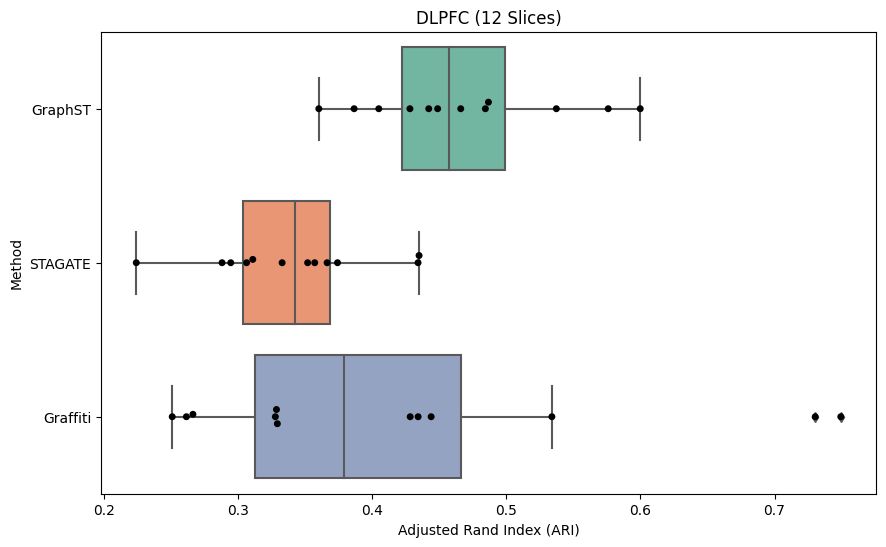

In [15]:
# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='Score', y='Method', data=df_melted, palette='Set2')
sns.swarmplot(x='Score', y='Method', data=df_melted, color='k', size=5)

# Customizing the plot
plt.xlabel('Adjusted Rand Index (ARI)')
plt.ylabel('Method')
plt.title('DLPFC (12 Slices)')
plt.show()

In [18]:
adata_graphst = sc.read_h5ad(f'{datadir}/graphst/0.2_graphst_seeded.h5ad')

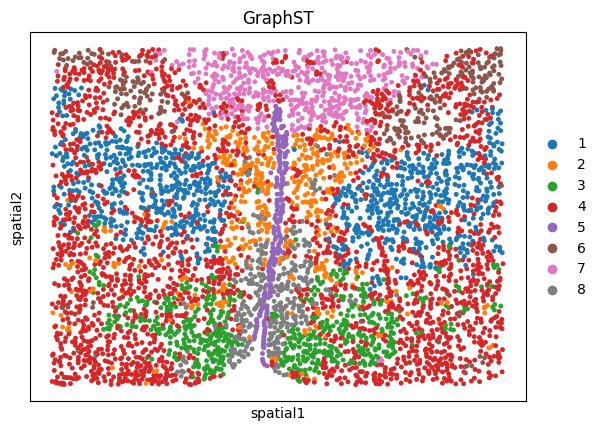

In [21]:
sc.pl.embedding(adata_graphst, basis='spatial', title = 'GraphST', color ='domain', s=50)